In [25]:
# -*- coding: utf-8 -*-
"""
Neural Network Efficiency Analyzer (NNEfficiency)
A comprehensive toolkit for analyzing, visualizing, and optimizing neural network efficiency
through weight importance analysis, pruning recommendations, and computational cost estimation.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Framework detection
try:
    import tensorflow as tf
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False

try:
    import torch
    import torch.nn as nn
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False


class LayerAnalysis:
    """Container for layer-specific analysis results"""
    def __init__(self, name: str, layer_type: str):
        self.name = name
        self.layer_type = layer_type
        self.importance_matrix = None
        self.weights = None
        self.metrics = {}

    def compute_metrics(self):
        """Compute comprehensive metrics for this layer"""
        if self.importance_matrix is None:
            return

        flat_importance = self.importance_matrix.flatten()
        total_sum = np.sum(flat_importance)

        if total_sum > 0:
            normalized = flat_importance / total_sum
        else:
            normalized = flat_importance

        # Entropy-based metrics
        entropy = -np.sum(normalized * np.log(normalized + 1e-10))
        max_entropy = np.log(len(normalized))
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0

        # Sparsity metrics
        threshold_1e2 = np.sum(flat_importance < 1e-2) / len(flat_importance)
        threshold_1e3 = np.sum(flat_importance < 1e-3) / len(flat_importance)

        # Concentration metrics (Gini coefficient)
        sorted_imp = np.sort(flat_importance)
        n = len(sorted_imp)
        cumsum = np.cumsum(sorted_imp)
        gini = (2 * np.sum((np.arange(n) + 1) * sorted_imp)) / (n * np.sum(sorted_imp)) - (n + 1) / n

        # Top-k coverage
        sorted_desc = np.sort(flat_importance)[::-1]
        cumsum_desc = np.cumsum(sorted_desc)
        total = cumsum_desc[-1]
        top10_coverage = np.searchsorted(cumsum_desc, 0.5 * total) / len(flat_importance)
        top20_coverage = np.searchsorted(cumsum_desc, 0.8 * total) / len(flat_importance)
        top50_coverage = np.searchsorted(cumsum_desc, 0.9 * total) / len(flat_importance)

        self.metrics = {
            'total_params': len(flat_importance),
            'entropy': entropy,
            'normalized_entropy': normalized_entropy,
            'effective_params': np.exp(entropy),
            'utilization_ratio': np.exp(entropy) / len(flat_importance),
            'sparsity_1e-2': threshold_1e2,
            'sparsity_1e-3': threshold_1e3,
            'gini_coefficient': gini,
            'top10_coverage': top10_coverage,
            'top20_coverage': top20_coverage,
            'top50_coverage': top50_coverage,
            'mean_importance': np.mean(flat_importance),
            'std_importance': np.std(flat_importance),
            'max_importance': np.max(flat_importance),
            'redundancy_score': 1 - normalized_entropy,  # Higher = more redundant
        }


class NNEfficiencyAnalyzer:
    """Main analyzer class for neural network efficiency analysis"""

    def __init__(self, model, framework: str = 'auto'):
        self.model = model
        self.framework = self._detect_framework(framework)
        self.layer_analyses: List[LayerAnalysis] = []
        self.global_metrics = {}

    def _detect_framework(self, framework: str) -> str:
        """Detect the deep learning framework"""
        if framework != 'auto':
            return framework

        if TF_AVAILABLE and isinstance(self.model, (tf.keras.Model, tf.keras.Sequential)):
            return 'tensorflow'
        elif TORCH_AVAILABLE and isinstance(self.model, nn.Module):
            return 'pytorch'
        else:
            raise ValueError("Could not detect framework. Please specify 'tensorflow' or 'pytorch'")

    def analyze(self, sample_data: np.ndarray, compute_activations: bool = True) -> Dict:
        """
        Perform comprehensive analysis of the neural network

        Args:
            sample_data: Representative input data for activation analysis
            compute_activations: Whether to compute activation-based importance

        Returns:
            Dictionary containing analysis results
        """
        print("🔍 Analyzing neural network efficiency...")

        if self.framework == 'tensorflow':
            self._analyze_tensorflow(sample_data, compute_activations)
        elif self.framework == 'pytorch':
            self._analyze_pytorch(sample_data, compute_activations)

        self._compute_global_metrics()

        print("✅ Analysis complete!")
        return self.get_summary()

    def _analyze_tensorflow(self, sample_data: np.ndarray, compute_activations: bool):
        """Analyze TensorFlow/Keras model"""
        current_input = sample_data.copy()

        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                analysis = LayerAnalysis(layer.name, 'Dense')
                weights, biases = layer.get_weights()

                if compute_activations:
                    z = np.dot(current_input, weights) + biases
                    activations = layer.activation(z)
                    avg_activation = np.mean(np.abs(activations.numpy() if isinstance(activations, tf.Tensor) else activations), axis=0)
                    importance = np.abs(weights) * avg_activation
                    current_input = activations.numpy() if isinstance(activations, tf.Tensor) else activations
                else:
                    importance = np.abs(weights)

                analysis.weights = weights
                analysis.importance_matrix = importance
                analysis.compute_metrics()
                self.layer_analyses.append(analysis)

            elif isinstance(layer, tf.keras.layers.Conv2D):
                analysis = LayerAnalysis(layer.name, 'Conv2D')
                weights = layer.get_weights()[0]
                # For conv layers, flatten and use magnitude
                importance = np.abs(weights).reshape(-1)
                analysis.weights = weights
                analysis.importance_matrix = importance
                analysis.compute_metrics()
                self.layer_analyses.append(analysis)

    def _analyze_pytorch(self, sample_data: np.ndarray, compute_activations: bool):
        """Analyze PyTorch model"""
        self.model.eval()

        if isinstance(sample_data, np.ndarray):
            current_input = torch.tensor(sample_data, dtype=torch.float32)
        else:
            current_input = sample_data.clone().detach().float()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                analysis = LayerAnalysis(name if name else 'linear', 'Linear')

                with torch.no_grad():
                    if compute_activations:
                        z = module(current_input)
                        activations = torch.relu(z)
                        avg_activation = torch.mean(torch.abs(activations), dim=0)
                        importance = torch.abs(module.weight) * avg_activation.unsqueeze(1)
                        current_input = activations
                    else:
                        importance = torch.abs(module.weight)

                analysis.weights = module.weight.detach().numpy()
                analysis.importance_matrix = importance.numpy().T
                analysis.compute_metrics()
                self.layer_analyses.append(analysis)

            elif isinstance(module, nn.Conv2d):
                analysis = LayerAnalysis(name if name else 'conv2d', 'Conv2d')
                importance = torch.abs(module.weight).detach().numpy()
                analysis.weights = module.weight.detach().numpy()
                analysis.importance_matrix = importance.reshape(-1)
                analysis.compute_metrics()
                self.layer_analyses.append(analysis)

    def _compute_global_metrics(self):
        """Compute global model-level metrics"""
        total_params = sum(la.metrics['total_params'] for la in self.layer_analyses)
        effective_params = sum(la.metrics['effective_params'] for la in self.layer_analyses)

        all_importances = np.concatenate([la.importance_matrix.flatten() for la in self.layer_analyses])

        self.global_metrics = {
            'total_parameters': total_params,
            'effective_parameters': effective_params,
            'global_utilization': effective_params / total_params if total_params > 0 else 0,
            'num_layers': len(self.layer_analyses),
            'avg_layer_redundancy': np.mean([la.metrics['redundancy_score'] for la in self.layer_analyses]),
            'global_sparsity_1e-2': np.sum(all_importances < 1e-2) / len(all_importances),
            'compression_potential': 1 - (effective_params / total_params) if total_params > 0 else 0,
        }

    def get_summary(self) -> Dict:
        """Get comprehensive analysis summary"""
        return {
            'global_metrics': self.global_metrics,
            'layer_analyses': [
                {
                    'name': la.name,
                    'type': la.layer_type,
                    'metrics': la.metrics
                }
                for la in self.layer_analyses
            ]
        }

    def print_report(self):
        """Print detailed analysis report"""
        print("\n" + "="*70)
        print("📊 NEURAL NETWORK EFFICIENCY REPORT")
        print("="*70)

        print("\n🌐 GLOBAL METRICS:")
        print(f"  Total Parameters: {self.global_metrics['total_parameters']:,}")
        print(f"  Effective Parameters: {self.global_metrics['effective_parameters']:.2f}")
        print(f"  Global Utilization: {self.global_metrics['global_utilization']*100:.2f}%")
        print(f"  Compression Potential: {self.global_metrics['compression_potential']*100:.2f}%")
        print(f"  Average Layer Redundancy: {self.global_metrics['avg_layer_redundancy']*100:.2f}%")

        print("\n📋 LAYER-BY-LAYER ANALYSIS:")
        for la in self.layer_analyses:
            print(f"\n  🔸 {la.name} ({la.layer_type})")
            print(f"     Parameters: {la.metrics['total_params']:,}")
            print(f"     Utilization: {la.metrics['utilization_ratio']*100:.2f}%")
            print(f"     Redundancy: {la.metrics['redundancy_score']*100:.2f}%")
            print(f"     Sparsity (<1e-2): {la.metrics['sparsity_1e-2']*100:.2f}%")
            print(f"     Gini Coefficient: {la.metrics['gini_coefficient']:.3f}")

        print("\n" + "="*70)
        self._print_recommendations()

    def _print_recommendations(self):
        """Print optimization recommendations"""
        print("\n💡 OPTIMIZATION RECOMMENDATIONS:")

        # Find most redundant layers
        redundant_layers = sorted(
            [(la.name, la.metrics['redundancy_score']) for la in self.layer_analyses],
            key=lambda x: x[1],
            reverse=True
        )[:3]

        if redundant_layers[0][1] > 0.7:
            print(f"\n  ⚠️  High Redundancy Detected:")
            for name, score in redundant_layers:
                if score > 0.6:
                    print(f"     - Layer '{name}': {score*100:.1f}% redundancy")
                    print(f"       → Consider reducing neurons or applying pruning")

        # Check global utilization
        if self.global_metrics['global_utilization'] < 0.3:
            print(f"\n  ⚠️  Low Global Utilization ({self.global_metrics['global_utilization']*100:.1f}%)")
            print(f"     → Model may be oversized. Consider:")
            print(f"       - Reducing layer widths by 30-50%")
            print(f"       - Applying structured pruning")

        # Check sparsity
        if self.global_metrics['global_sparsity_1e-2'] > 0.5:
            print(f"\n  ✅ High Sparsity Detected ({self.global_metrics['global_sparsity_1e-2']*100:.1f}%)")
            print(f"     → Excellent candidate for weight pruning")
            print(f"     → Potential {self.global_metrics['compression_potential']*100:.1f}% compression")


class Visualizer:
    """Visualization utilities for network analysis"""

    @staticmethod
    def plot_layer_importance_distribution(analyzer: NNEfficiencyAnalyzer, figsize=(15, 10)):
        """Plot importance distribution for each layer"""
        num_layers = len(analyzer.layer_analyses)
        fig, axes = plt.subplots(2, (num_layers + 1) // 2, figsize=figsize)
        axes = axes.flatten() if num_layers > 1 else [axes]

        for idx, la in enumerate(analyzer.layer_analyses):
            ax = axes[idx]
            flat_imp = la.importance_matrix.flatten()

            ax.hist(flat_imp, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_title(f'{la.name}\nUtilization: {la.metrics["utilization_ratio"]*100:.1f}%',
                        fontsize=10, fontweight='bold')
            ax.set_xlabel('Importance', fontsize=8)
            ax.set_ylabel('Count', fontsize=8)
            ax.grid(True, alpha=0.3)

            # Add threshold line
            ax.axvline(1e-2, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold')
            ax.legend(fontsize=7)

        # Hide unused subplots
        for idx in range(num_layers, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.suptitle('Weight Importance Distribution by Layer', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

    @staticmethod
    def plot_layer_comparison(analyzer: NNEfficiencyAnalyzer, figsize=(12, 6)):
        """Compare metrics across layers"""
        layer_names = [la.name for la in analyzer.layer_analyses]
        metrics_to_plot = ['utilization_ratio', 'redundancy_score', 'sparsity_1e-2']

        fig, axes = plt.subplots(1, 3, figsize=figsize)

        for idx, metric in enumerate(metrics_to_plot):
            values = [la.metrics[metric] * 100 for la in analyzer.layer_analyses]
            colors = sns.color_palette("RdYlGn_r" if metric == 'redundancy_score' else "RdYlGn", len(values))

            bars = axes[idx].bar(range(len(values)), values, color=colors, edgecolor='black')
            axes[idx].set_xticks(range(len(layer_names)))
            axes[idx].set_xticklabels(layer_names, rotation=45, ha='right')
            axes[idx].set_ylabel('Percentage (%)')
            axes[idx].set_title(metric.replace('_', ' ').title())
            axes[idx].grid(True, axis='y', alpha=0.3)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.suptitle('Layer-wise Metrics Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

    @staticmethod
    def plot_efficiency_radar(analyzer: NNEfficiencyAnalyzer, layer_idx: int = 0, figsize=(8, 8)):
        """Create radar chart for layer efficiency metrics"""
        from math import pi

        la = analyzer.layer_analyses[layer_idx]

        categories = ['Utilization', 'Sparsity', 'Gini\n(inequality)',
                     'Top 10%\nCoverage', 'Redundancy']
        values = [
            la.metrics['utilization_ratio'],
            la.metrics['sparsity_1e-2'],
            la.metrics['gini_coefficient'],
            la.metrics['top10_coverage'],
            la.metrics['redundancy_score']
        ]

        # Normalize to 0-100
        values = [v * 100 for v in values]

        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        values += values[:1]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
        ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
        ax.fill(angles, values, alpha=0.25, color='steelblue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=10)
        ax.set_ylim(0, 100)
        ax.set_title(f'Efficiency Profile: {la.name}', size=14, fontweight='bold', pad=20)
        ax.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_pruning_sensitivity(analyzer: NNEfficiencyAnalyzer, figsize=(12, 5)):
        """Visualize potential impact of pruning at different thresholds"""
        thresholds = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        for la in analyzer.layer_analyses:
            flat_imp = la.importance_matrix.flatten()
            pruned_ratios = [np.sum(flat_imp < t) / len(flat_imp) * 100 for t in thresholds]
            ax1.plot(range(len(thresholds)), pruned_ratios, marker='o', label=la.name, linewidth=2)

        ax1.set_xticks(range(len(thresholds)))
        ax1.set_xticklabels([f'{t:.0e}' for t in thresholds], rotation=45)
        ax1.set_xlabel('Pruning Threshold')
        ax1.set_ylabel('Weights Pruned (%)')
        ax1.set_title('Pruning Sensitivity Analysis')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Cumulative importance
        all_imp = np.concatenate([la.importance_matrix.flatten() for la in analyzer.layer_analyses])
        sorted_imp = np.sort(all_imp)[::-1]
        cumsum = np.cumsum(sorted_imp) / np.sum(sorted_imp) * 100

        ax2.plot(np.arange(len(cumsum)) / len(cumsum) * 100, cumsum, linewidth=2, color='darkgreen')
        ax2.axhline(90, color='red', linestyle='--', alpha=0.5, label='90% importance')
        ax2.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80% importance')
        ax2.set_xlabel('Percentage of Weights (%)')
        ax2.set_ylabel('Cumulative Importance (%)')
        ax2.set_title('Cumulative Weight Importance')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


def quick_analyze(model, sample_data: np.ndarray, framework: str = 'auto',
                  visualize: bool = True) -> NNEfficiencyAnalyzer:
    """
    Convenience function for quick model analysis

    Args:
        model: Neural network model (TensorFlow or PyTorch)
        sample_data: Representative input data
        framework: 'tensorflow', 'pytorch', or 'auto'
        visualize: Whether to show visualizations

    Returns:
        NNEfficiencyAnalyzer instance with results
    """
    analyzer = NNEfficiencyAnalyzer(model, framework)
    analyzer.analyze(sample_data)
    analyzer.print_report()

    if visualize:
        viz = Visualizer()
        viz.plot_layer_importance_distribution(analyzer)
        viz.plot_layer_comparison(analyzer)
        viz.plot_pruning_sensitivity(analyzer)

    return analyzer

✅ Setup complete!
📊 Creating sample datasets...
   Train shape: (800, 20)
   Test shape: (200, 20)

🔥 TENSORFLOW/KERAS DEMONSTRATION

📚 Training TensorFlow model...
✅ Training complete! Final accuracy: 1.000

🔍 Analyzing TensorFlow model efficiency...
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

📊 NEURAL NETWORK EFFICIENCY REPORT

🌐 GLOBAL METRICS:
  Total Parameters: 13,360
  Effective Parameters: 8856.08
  Global Utilization: 66.29%
  Compression Potential: 33.71%
  Average Layer Redundancy: 5.00%

📋 LAYER-BY-LAYER ANALYSIS:

  🔸 hidden_1 (Dense)
     Parameters: 2,560
     Utilization: 79.47%
     Redundancy: 2.93%
     Sparsity (<1e-2): 21.21%
     Gini Coefficient: 0.371

  🔸 hidden_2 (Dense)
     Parameters: 8,192
     Utilization: 63.47%
     Redundancy: 5.05%
     Sparsity (<1e-2): 24.29%
     Gini Coefficient: 0.516

  🔸 hidden_3 (Dense)
     Parameters: 2,048
     Utilization: 59.67%
     Redundancy: 6.77%
     Sparsity (<1e-2): 16.31%
     Gini Coefficient:

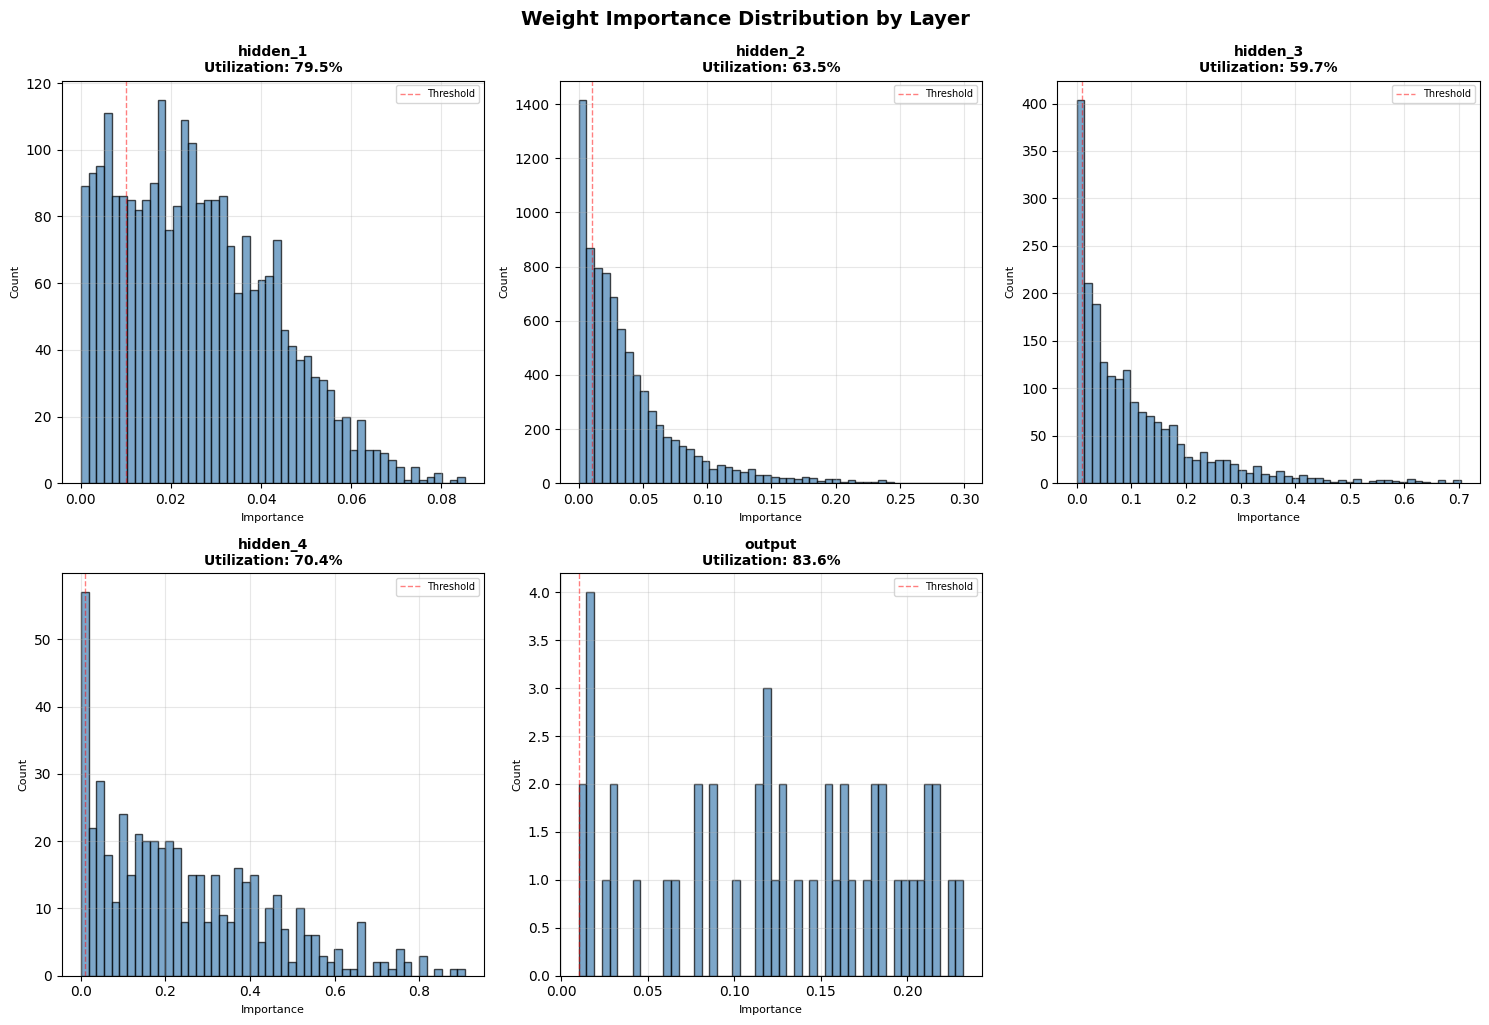

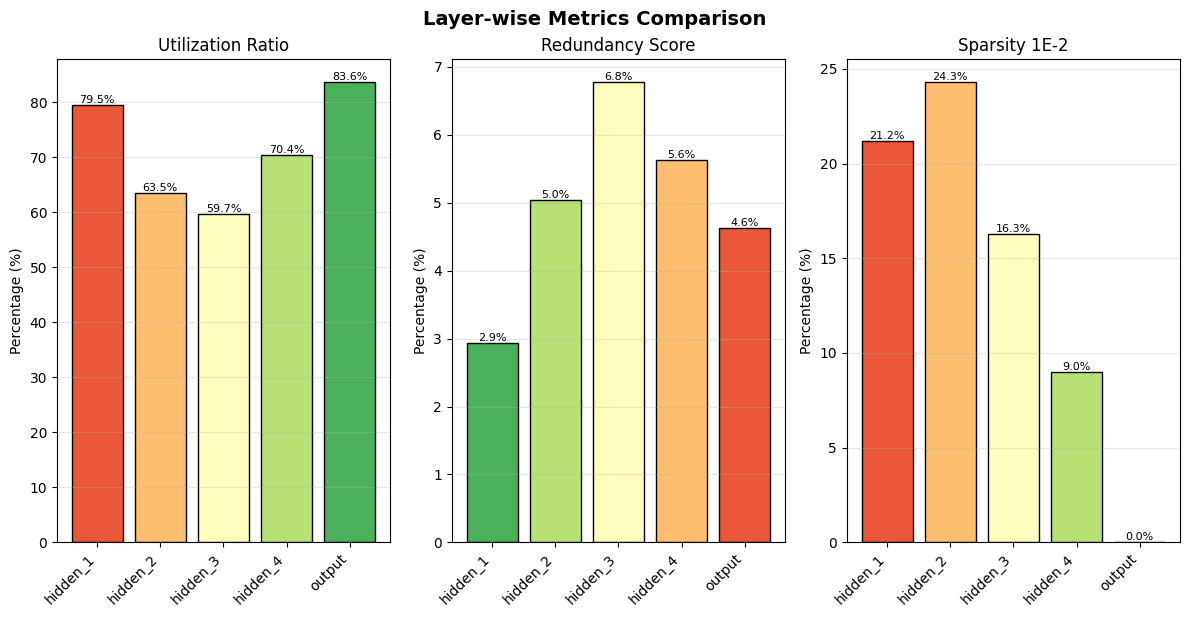

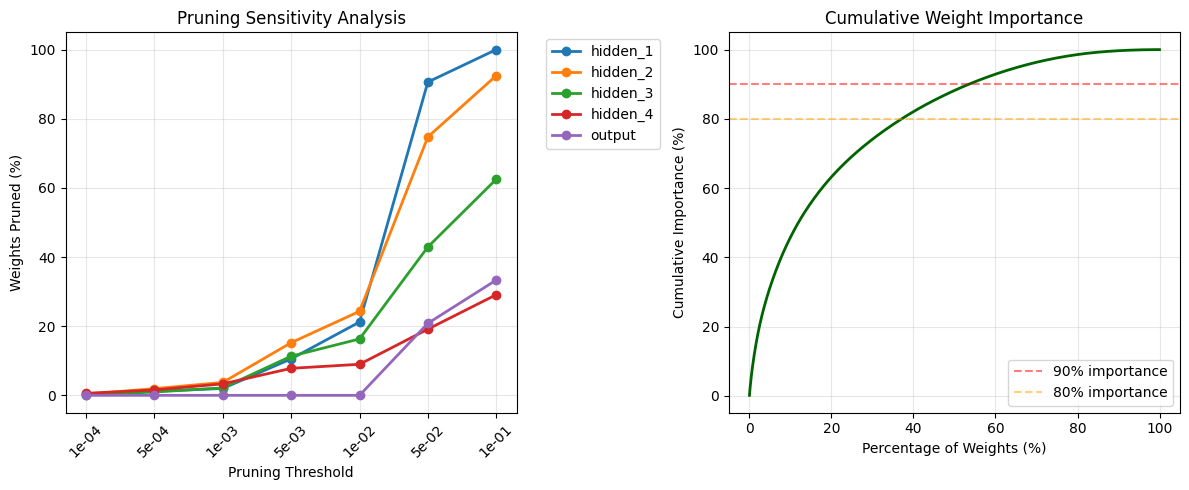


🔥 PYTORCH DEMONSTRATION

📚 Training PyTorch model...
✅ Training complete!

🔍 Analyzing PyTorch model efficiency...
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

📊 NEURAL NETWORK EFFICIENCY REPORT

🌐 GLOBAL METRICS:
  Total Parameters: 13,360
  Effective Parameters: 8162.95
  Global Utilization: 61.10%
  Compression Potential: 38.90%
  Average Layer Redundancy: 6.78%

📋 LAYER-BY-LAYER ANALYSIS:

  🔸 fc1 (Linear)
     Parameters: 2,560
     Utilization: 77.12%
     Redundancy: 3.31%
     Sparsity (<1e-2): 15.43%
     Gini Coefficient: 0.395

  🔸 fc2 (Linear)
     Parameters: 8,192
     Utilization: 59.52%
     Redundancy: 5.76%
     Sparsity (<1e-2): 19.43%
     Gini Coefficient: 0.545

  🔸 fc3 (Linear)
     Parameters: 2,048
     Utilization: 47.93%
     Redundancy: 9.64%
     Sparsity (<1e-2): 22.66%
     Gini Coefficient: 0.630

  🔸 fc4 (Linear)
     Parameters: 512
     Utilization: 57.31%
     Redundancy: 8.92%
     Sparsity (<1e-2): 21.48%
     Gini Coefficient: 0

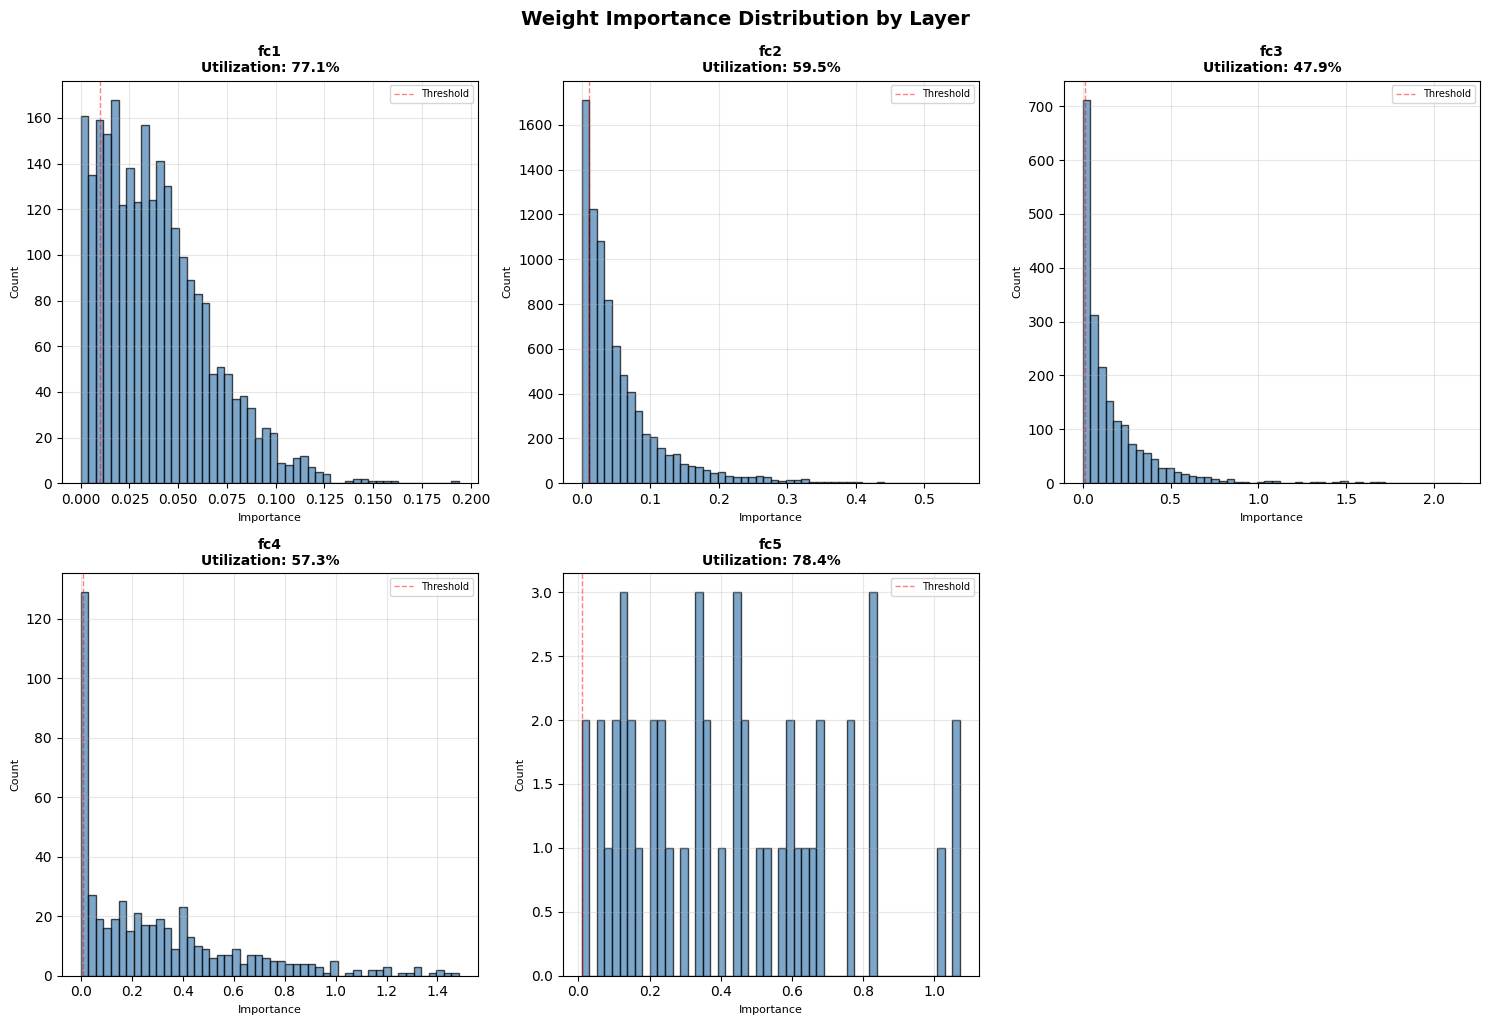

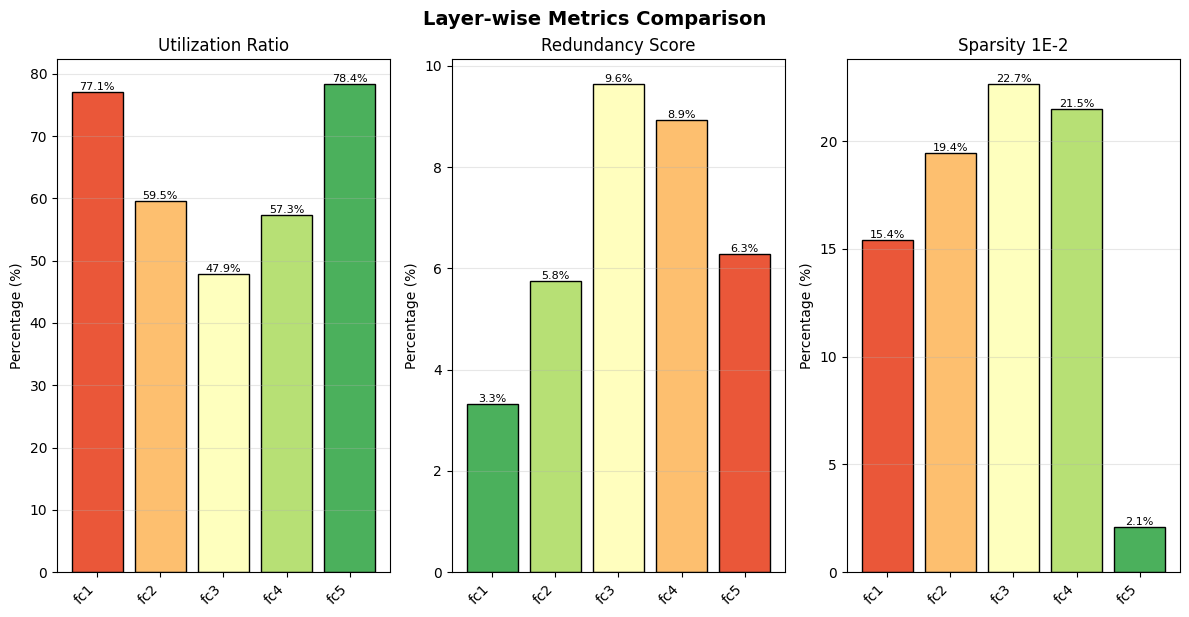

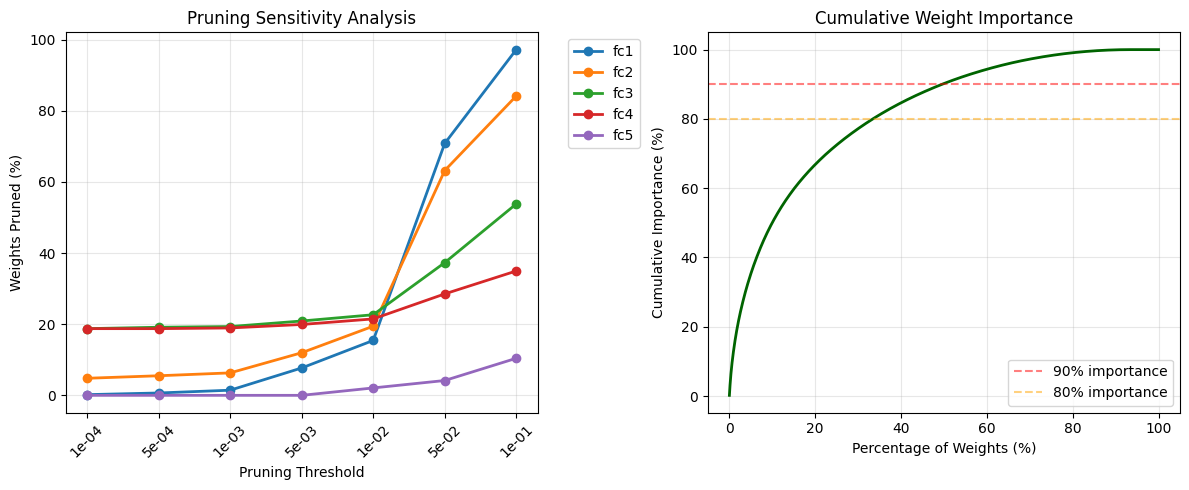


📊 ADVANCED ANALYSIS VISUALIZATIONS

🎯 Efficiency profile for first layer:


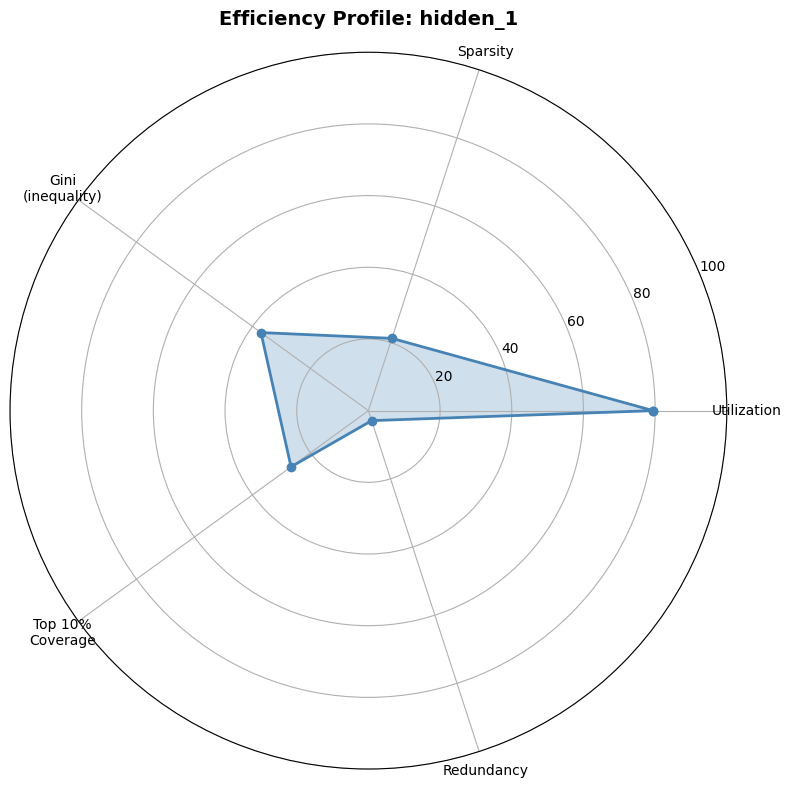


📊 Layer comparison:


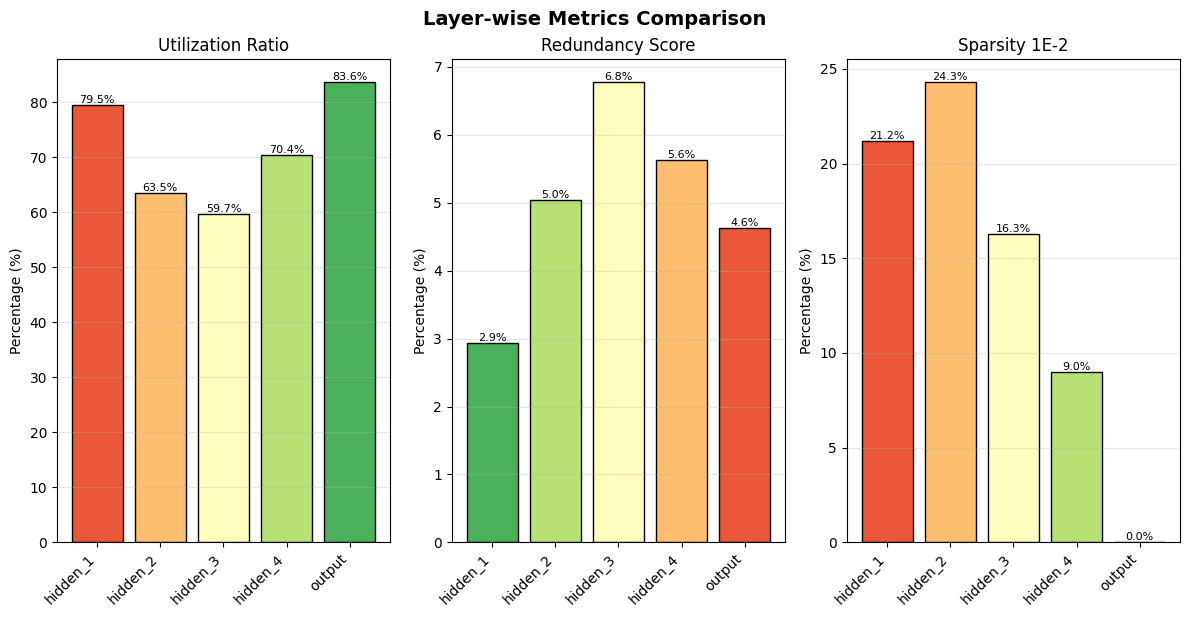


✂️ Pruning sensitivity analysis:


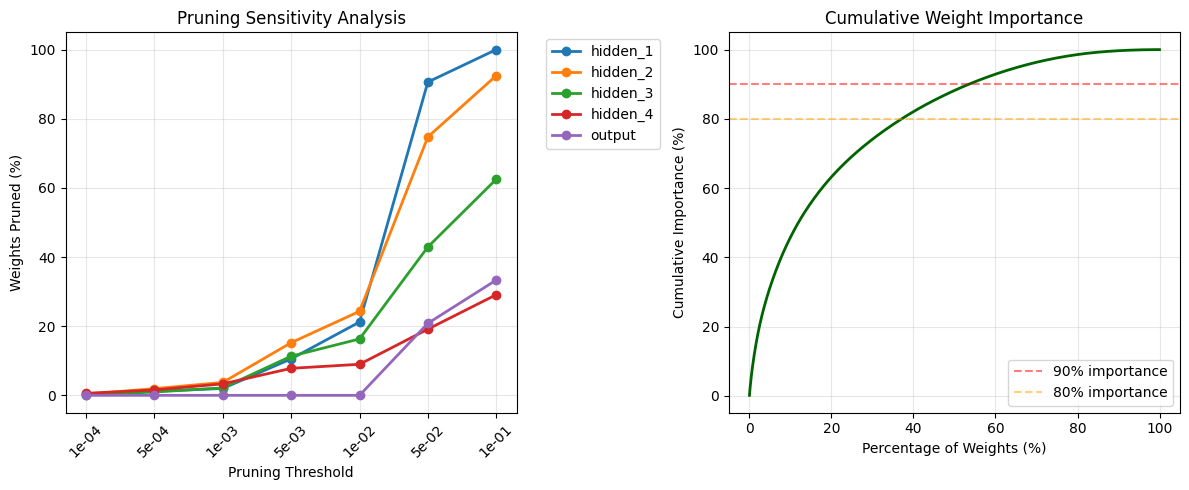


✂️ PRACTICAL PRUNING DEMONSTRATION

📊 Accuracy before pruning: 0.870

🔨 Applying magnitude-based pruning (threshold=1e-2)...
✂️ Pruned 1,048 / 13,360 parameters (7.84%)
📊 Accuracy after pruning: 0.875
📉 Accuracy drop: -0.005

🔍 Analyzing pruned model...
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

📊 NEURAL NETWORK EFFICIENCY REPORT

🌐 GLOBAL METRICS:
  Total Parameters: 13,360
  Effective Parameters: 10136.21
  Global Utilization: 75.87%
  Compression Potential: 24.13%
  Average Layer Redundancy: 3.97%

📋 LAYER-BY-LAYER ANALYSIS:

  🔸 fc1 (Linear)
     Parameters: 2,560
     Utilization: 79.79%
     Redundancy: 2.88%
     Sparsity (<1e-2): 4.18%
     Gini Coefficient: 0.362

  🔸 fc2 (Linear)
     Parameters: 8,192
     Utilization: 74.64%
     Redundancy: 3.25%
     Sparsity (<1e-2): 9.28%
     Gini Coefficient: 0.411

  🔸 fc3 (Linear)
     Parameters: 2,048
     Utilization: 75.34%
     Redundancy: 3.71%
     Sparsity (<1e-2): 7.32%
     Gini Coefficient: 0.407

  🔸

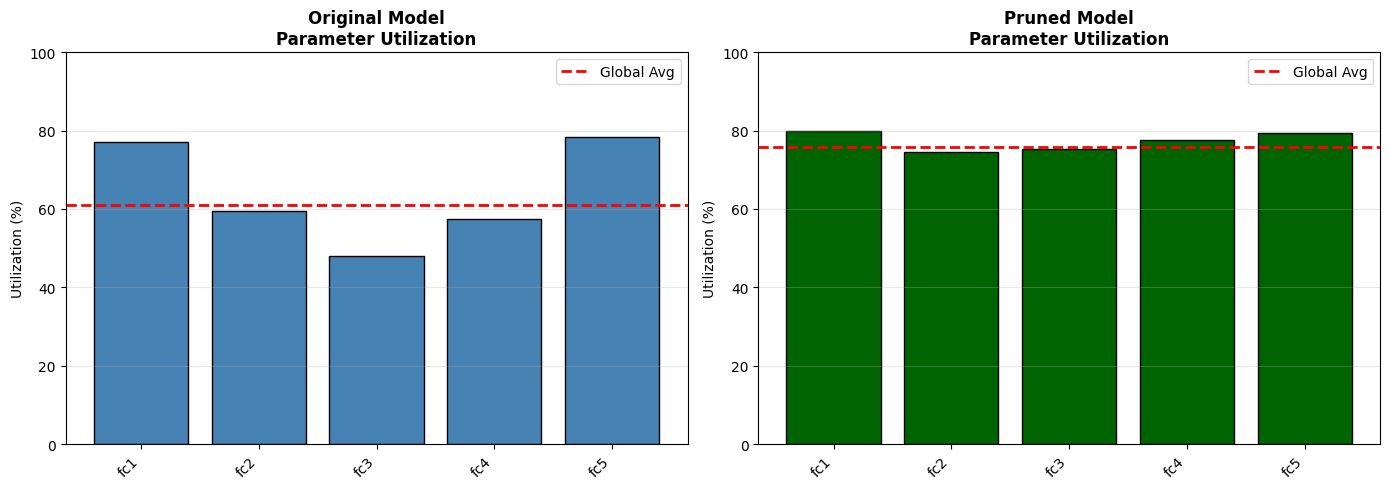


💾 EXPORT ANALYSIS RESULTS
✅ Results exported to original_model_analysis.json
✅ Results exported to pruned_model_analysis.json

🎯 FINAL RECOMMENDATIONS

Based on the analysis:

🔍 ORIGINAL MODEL:
   - Total parameters: 13,360
   - Effective parameters: 8163
   - Utilization: 61.1%
   - Compression potential: 38.9%

✂️ AFTER PRUNING:
   - Pruning rate: 7.8%
   - Accuracy impact: -0.50% loss
   - New utilization: 75.9%

💡 NEXT STEPS:
   1. Fine-tune the pruned model to recover accuracy
   2. Apply structured pruning for better hardware efficiency
   3. Consider quantization (INT8) for further compression
   4. Experiment with knowledge distillation to a smaller model
   
📚 FURTHER OPTIMIZATION:
   - Current model could be reduced by ~39%
   - Focus on layers with >70% redundancy score
   - Target sparsity: 19%



In [30]:
"""
Neural Network Efficiency Analyzer - Demonstration Notebook
============================================================
This notebook demonstrates how to analyze and optimize neural networks
using the NNEfficiency library.

Compatible with Google Colab!
"""
# ============================================================================
# 1. SETUP AND INSTALLATION
# ============================================================================

# Install required packages
# !pip install tensorflow torch matplotlib seaborn scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import the library (paste the NNEfficiency code above or import from file)
# from nn_efficiency import NNEfficiencyAnalyzer, Visualizer, quick_analyze

print("✅ Setup complete!")

# ============================================================================
# 2. CREATE SAMPLE DATASETS
# ============================================================================

def create_sample_data(task='classification', n_samples=1000, n_features=20):
    """Generate sample data for demonstration"""
    if task == 'classification':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=15,
            n_redundant=3,
            n_classes=3,
            random_state=42
        )
    else:
        X, y = make_regression(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=15,
            noise=0.1,
            random_state=42
        )

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)

print("📊 Creating sample datasets...")
X_train, X_test, y_train, y_test = create_sample_data('classification', n_samples=1000, n_features=20)
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")

# ============================================================================
# 3. TENSORFLOW/KERAS EXAMPLE
# ============================================================================

print("\n" + "="*70)
print("🔥 TENSORFLOW/KERAS DEMONSTRATION")
print("="*70)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create an intentionally oversized model
tf_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(20,), name='hidden_1'),
    layers.Dense(64, activation='relu', name='hidden_2'),
    layers.Dense(32, activation='relu', name='hidden_3'),
    layers.Dense(16, activation='relu', name='hidden_4'),
    layers.Dense(3, activation='softmax', name='output')
])

tf_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📚 Training TensorFlow model...")
history = tf_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

print(f"✅ Training complete! Final accuracy: {history.history['accuracy'][-1]:.3f}")

# Analyze the model
print("\n🔍 Analyzing TensorFlow model efficiency...")
tf_analyzer = quick_analyze(tf_model, X_train, framework='tensorflow', visualize=True)

# ============================================================================
# 4. PYTORCH EXAMPLE
# ============================================================================

print("\n" + "="*70)
print("🔥 PYTORCH DEMONSTRATION")
print("="*70)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Create PyTorch model
class OversizedNet(nn.Module):
    def __init__(self):
        super(OversizedNet, self).__init__()
        self.fc1 = nn.Linear(20, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

torch_model = OversizedNet()

# Prepare data
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.LongTensor(y_train)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters())

print("\n📚 Training PyTorch model...")
torch_model.train()
for epoch in range(20):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = torch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("✅ Training complete!")

# Analyze the model
print("\n🔍 Analyzing PyTorch model efficiency...")
torch_analyzer = quick_analyze(torch_model, X_train, framework='pytorch', visualize=True)

# ============================================================================
# 5. ADVANCED VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("📊 ADVANCED ANALYSIS VISUALIZATIONS")
print("="*70)

viz = Visualizer()

# Radar chart for first layer
print("\n🎯 Efficiency profile for first layer:")
viz.plot_efficiency_radar(tf_analyzer, layer_idx=0)

# Compare multiple layers
print("\n📊 Layer comparison:")
viz.plot_layer_comparison(tf_analyzer)

# Pruning sensitivity
print("\n✂️ Pruning sensitivity analysis:")
viz.plot_pruning_sensitivity(tf_analyzer)

# ============================================================================
# 6. PRACTICAL PRUNING DEMONSTRATION
# ============================================================================

print("\n" + "="*70)
print("✂️ PRACTICAL PRUNING DEMONSTRATION")
print("="*70)

def apply_magnitude_pruning(model, threshold=1e-2):
    """Apply magnitude-based pruning to PyTorch model"""
    pruned_params = 0
    total_params = 0

    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                mask = torch.abs(param) > threshold
                param.mul_(mask.float())
                pruned_params += (~mask).sum().item()
                total_params += param.numel()

    pruning_rate = pruned_params / total_params * 100
    print(f"✂️ Pruned {pruned_params:,} / {total_params:,} parameters ({pruning_rate:.2f}%)")
    return pruning_rate

# Create a copy for pruning
import copy
pruned_model = copy.deepcopy(torch_model)

# Evaluate before pruning
torch_model.eval()
with torch.no_grad():
    X_test_torch = torch.FloatTensor(X_test)
    y_test_torch = torch.LongTensor(y_test)
    outputs_before = torch_model(X_test_torch)
    _, predicted_before = torch.max(outputs_before, 1)
    accuracy_before = (predicted_before == y_test_torch).sum().item() / len(y_test_torch)

print(f"\n📊 Accuracy before pruning: {accuracy_before:.3f}")

# Apply pruning
print("\n🔨 Applying magnitude-based pruning (threshold=1e-2)...")
pruning_rate = apply_magnitude_pruning(pruned_model, threshold=1e-2)

# Evaluate after pruning
pruned_model.eval()
with torch.no_grad():
    outputs_after = pruned_model(X_test_torch)
    _, predicted_after = torch.max(outputs_after, 1)
    accuracy_after = (predicted_after == y_test_torch).sum().item() / len(y_test_torch)

print(f"📊 Accuracy after pruning: {accuracy_after:.3f}")
print(f"📉 Accuracy drop: {(accuracy_before - accuracy_after):.3f}")

# Re-analyze pruned model
print("\n🔍 Analyzing pruned model...")
pruned_analyzer = NNEfficiencyAnalyzer(pruned_model, framework='pytorch')
pruned_analyzer.analyze(X_train, compute_activations=False)
pruned_analyzer.print_report()

# ============================================================================
# 7. COMPARISON VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("📊 BEFORE vs AFTER PRUNING COMPARISON")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original model
utilizations_before = [la.metrics['utilization_ratio'] * 100 for la in torch_analyzer.layer_analyses]
layer_names = [la.name for la in torch_analyzer.layer_analyses]

axes[0].bar(range(len(utilizations_before)), utilizations_before, color='steelblue', edgecolor='black')
axes[0].set_title('Original Model\nParameter Utilization', fontweight='bold')
axes[0].set_xticks(range(len(layer_names)))
axes[0].set_xticklabels(layer_names, rotation=45, ha='right')
axes[0].set_ylabel('Utilization (%)')
axes[0].set_ylim(0, 100)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].axhline(torch_analyzer.global_metrics['global_utilization'] * 100,
               color='red', linestyle='--', label='Global Avg', linewidth=2)
axes[0].legend()

# Pruned model
utilizations_after = [la.metrics['utilization_ratio'] * 100 for la in pruned_analyzer.layer_analyses]

axes[1].bar(range(len(utilizations_after)), utilizations_after, color='darkgreen', edgecolor='black')
axes[1].set_title('Pruned Model\nParameter Utilization', fontweight='bold')
axes[1].set_xticks(range(len(layer_names)))
axes[1].set_xticklabels(layer_names, rotation=45, ha='right')
axes[1].set_ylabel('Utilization (%)')
axes[1].set_ylim(0, 100)
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].axhline(pruned_analyzer.global_metrics['global_utilization'] * 100,
               color='red', linestyle='--', label='Global Avg', linewidth=2)
axes[1].legend()

plt.tight_layout()
plt.show()

# ============================================================================
# 8. EXPORT RESULTS
# ============================================================================

print("\n" + "="*70)
print("💾 EXPORT ANALYSIS RESULTS")
print("="*70)

import json

def json_numpy_serializer(obj):
    """Custom JSON serializer for numpy types"""
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    # You can add other numpy types if your data might contain them
    # For example, to handle numpy integers:
    # elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
    #     return int(obj)
    # Or numpy arrays to lists:
    # elif isinstance(obj, np.ndarray):
    #     return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

def export_analysis(analyzer, filename='analysis_results.json'):
    """Export analysis results to JSON"""
    results = analyzer.get_summary()
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2, default=json_numpy_serializer)
    print(f"✅ Results exported to {filename}")

export_analysis(torch_analyzer, 'original_model_analysis.json')
export_analysis(pruned_analyzer, 'pruned_model_analysis.json')

# ============================================================================
# 9. CONCLUSION AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATIONS")
print("="*70)

print(f"""
Based on the analysis:

🔍 ORIGINAL MODEL:
   - Total parameters: {torch_analyzer.global_metrics['total_parameters']:,}
   - Effective parameters: {torch_analyzer.global_metrics['effective_parameters']:.0f}
   - Utilization: {torch_analyzer.global_metrics['global_utilization']*100:.1f}%
   - Compression potential: {torch_analyzer.global_metrics['compression_potential']*100:.1f}%

✂️ AFTER PRUNING:
   - Pruning rate: {pruning_rate:.1f}%
   - Accuracy impact: {(accuracy_before - accuracy_after)*100:.2f}% loss
   - New utilization: {pruned_analyzer.global_metrics['global_utilization']*100:.1f}%

💡 NEXT STEPS:
   1. Fine-tune the pruned model to recover accuracy
   2. Apply structured pruning for better hardware efficiency
   3. Consider quantization (INT8) for further compression
   4. Experiment with knowledge distillation to a smaller model

📚 FURTHER OPTIMIZATION:
   - Current model could be reduced by ~{torch_analyzer.global_metrics['compression_potential']*100:.0f}%
   - Focus on layers with >70% redundancy score
   - Target sparsity: {torch_analyzer.global_metrics['global_sparsity_1e-2']*100:.0f}%
""")

EXEMPLE 1: Analyse en 5 lignes de code
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

📊 NEURAL NETWORK EFFICIENCY REPORT

🌐 GLOBAL METRICS:
  Total Parameters: 3,648
  Effective Parameters: 2653.87
  Global Utilization: 72.75%
  Compression Potential: 27.25%
  Average Layer Redundancy: 4.31%

📋 LAYER-BY-LAYER ANALYSIS:

  🔸 dense_26 (Dense)
     Parameters: 1,280
     Utilization: 80.75%
     Redundancy: 2.99%
     Sparsity (<1e-2): 15.16%
     Gini Coefficient: 0.353

  🔸 dense_27 (Dense)
     Parameters: 2,048
     Utilization: 67.22%
     Redundancy: 5.21%
     Sparsity (<1e-2): 28.96%
     Gini Coefficient: 0.488

  🔸 dense_28 (Dense)
     Parameters: 320
     Utilization: 76.13%
     Redundancy: 4.73%
     Sparsity (<1e-2): 31.87%
     Gini Coefficient: 0.408


💡 OPTIMIZATION RECOMMENDATIONS:


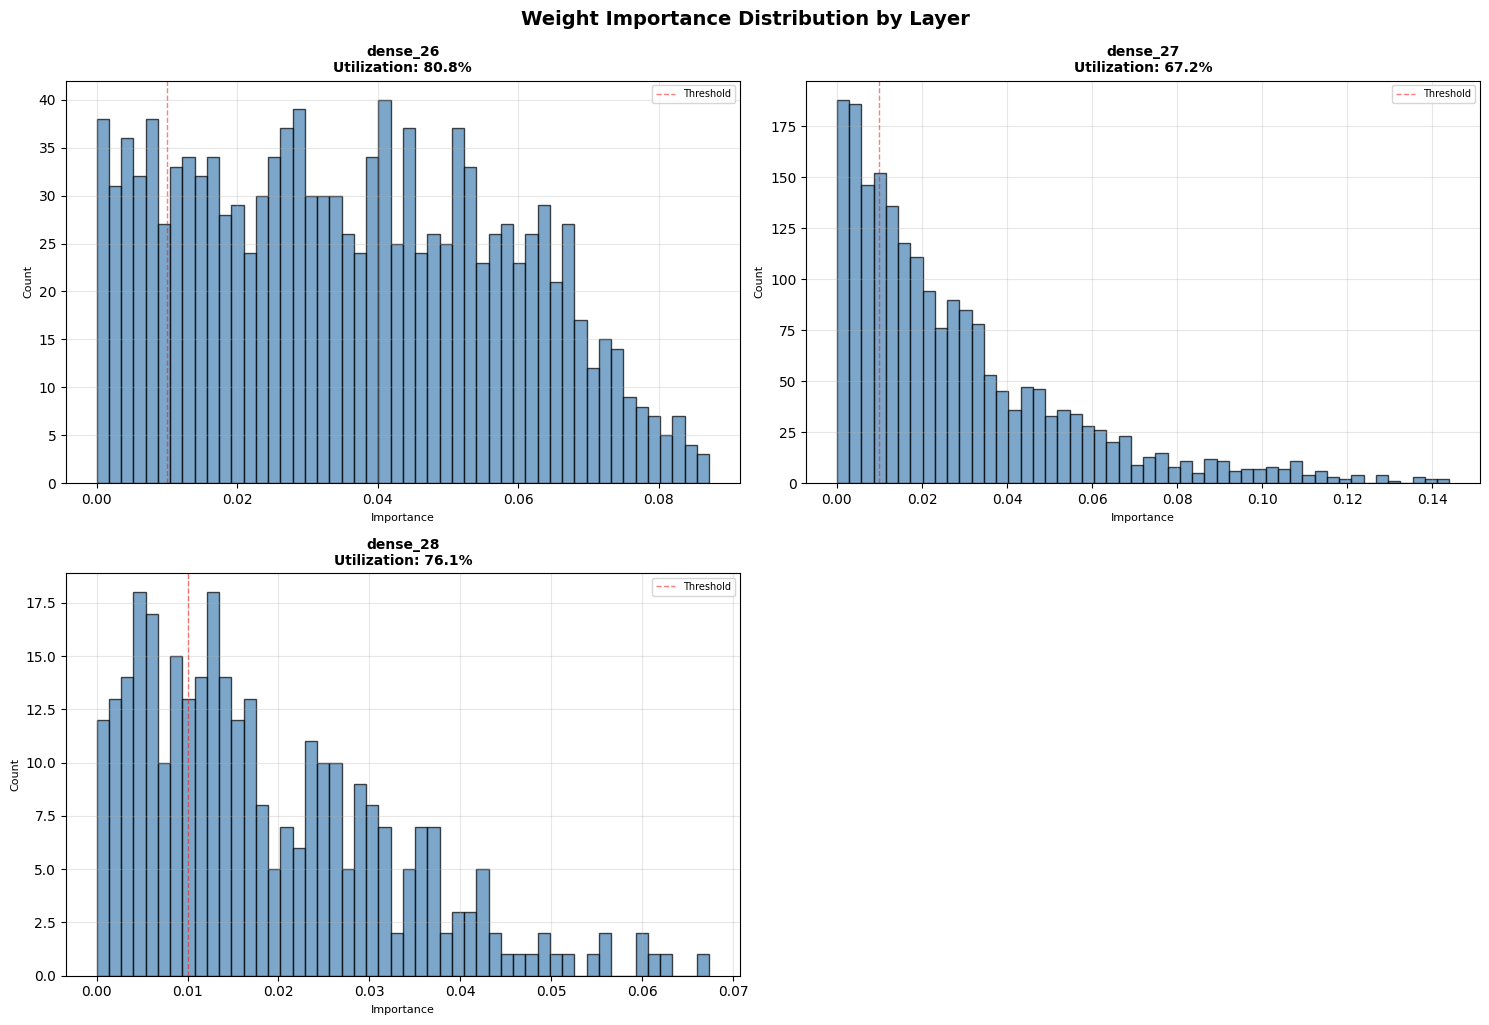

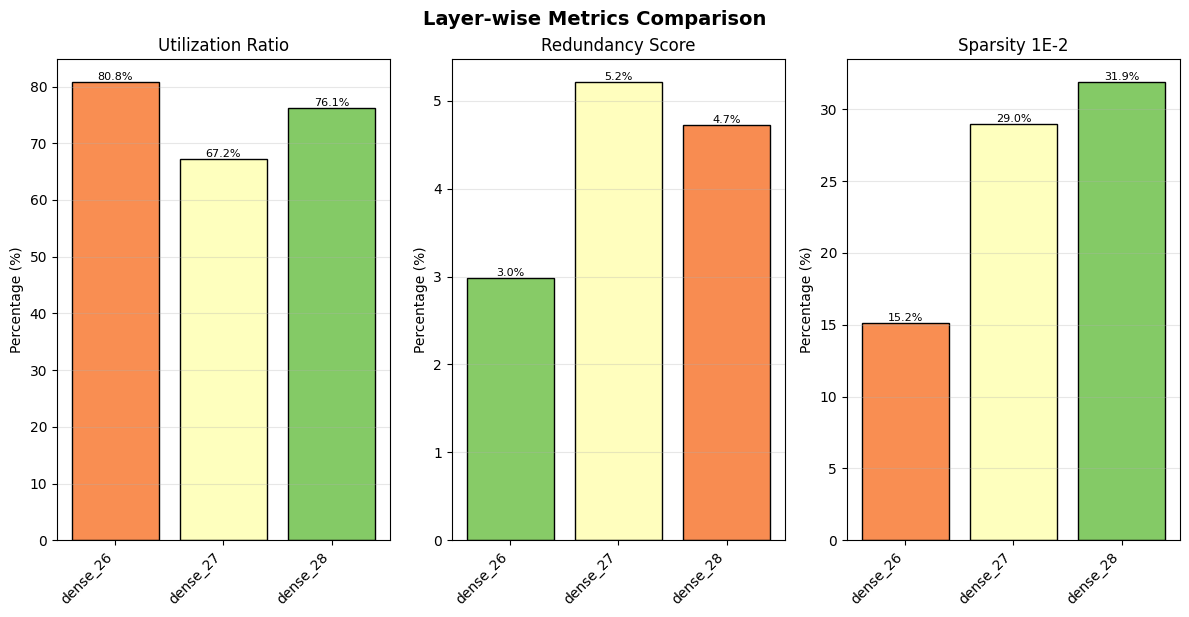

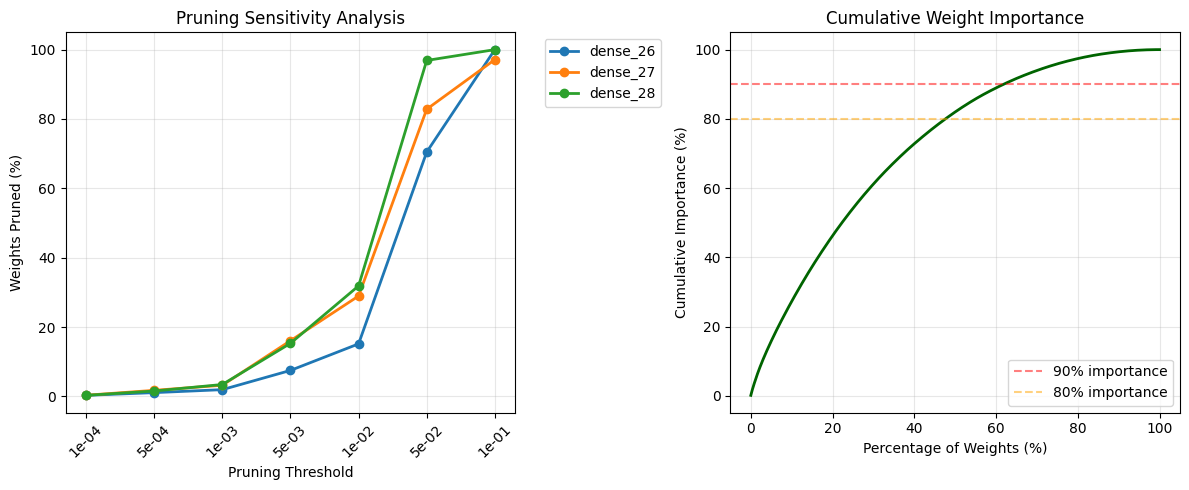


EXEMPLE 2: Détecter si votre modèle est surdimensionné
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

✅ Modèle correctement dimensionné

🔍 Couches les plus redondantes:
   - dense_31: 5.7% redondance
   - dense_30: 3.6% redondance
   - dense_32: 2.7% redondance

EXEMPLE 3: Déterminer le seuil optimal de pruning

📊 Génération du graphique de sensibilité...


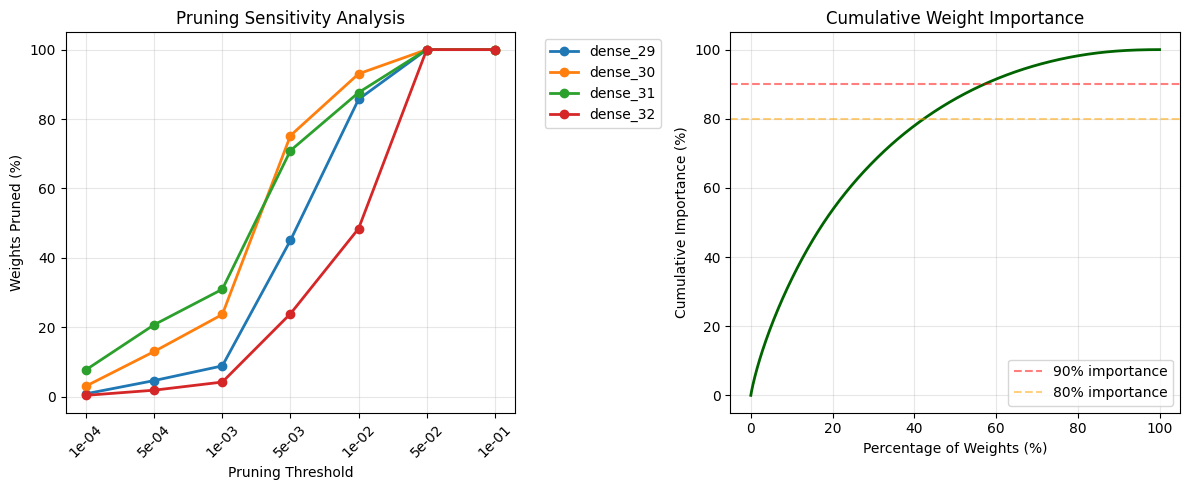


✂️ Couches candidates pour le pruning (>40% sparsité):
   - dense_29: 85.7% de poids faibles
     → Peut être pruné en toute sécurité
   - dense_30: 93.0% de poids faibles
     → Peut être pruné en toute sécurité
   - dense_31: 87.6% de poids faibles
     → Peut être pruné en toute sécurité
   - dense_32: 48.4% de poids faibles
     → Peut être pruné en toute sécurité

EXEMPLE 4: Comparer l'efficacité de plusieurs architectures
🔍 Analyzing neural network efficiency...
✅ Analysis complete!
🔍 Analyzing neural network efficiency...
✅ Analysis complete!
🔍 Analyzing neural network efficiency...
✅ Analysis complete!
🔍 Analyzing neural network efficiency...
✅ Analysis complete!

📊 Comparaison des architectures:
Architecture        Params  Utilisation      Score
--------------------------------------------------
Compact              1,288        82.5%     0.6403
Small                1,760        81.3%     0.4620
Medium               4,400        82.4%     0.1873
Large               13,520    

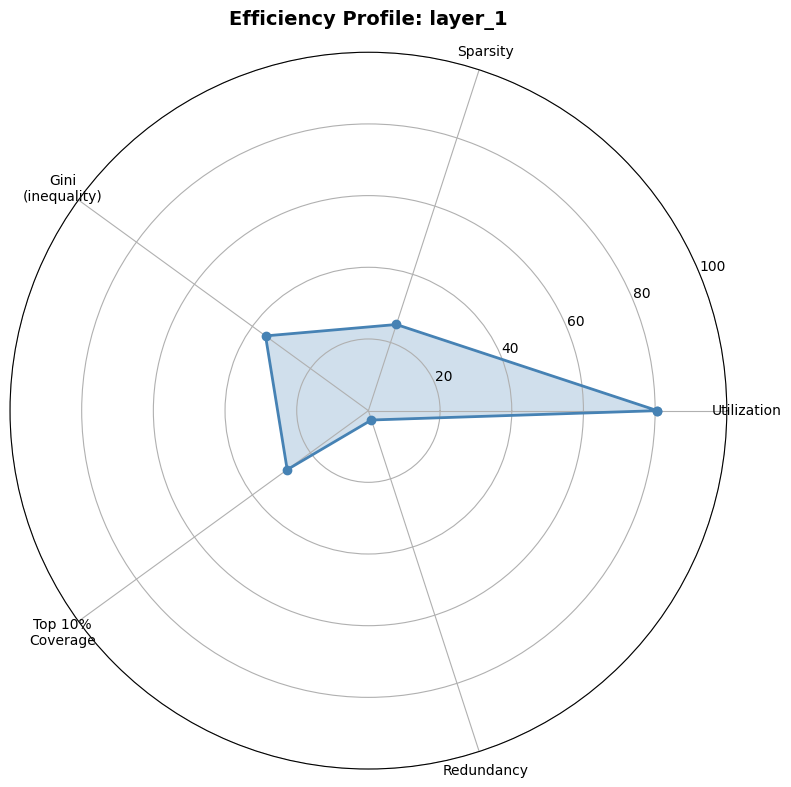


EXEMPLE 6: Exporter les résultats d'analyse
✅ Résultats sauvegardés dans 'model_analysis.json'
✅ Rapport personnalisé sauvegardé dans 'custom_report.json'

EXEMPLE 7: Workflow complet - De l'analyse au pruning

🔍 ÉTAPE 1: Analyse du modèle original
🔍 Analyzing neural network efficiency...
✅ Analysis complete!
   Utilisation: 64.8%
   Paramètres: 11,392

✂️ ÉTAPE 2: Application du pruning (seuil=0.01)
   Paramètres éliminés: 1,126 / 11,392 (9.9%)

📊 ÉTAPE 3: Analyse du modèle après pruning
🔍 Analyzing neural network efficiency...
✅ Analysis complete!
   Nouvelle utilisation: 79.5%

📈 ÉTAPE 4: Comparaison avant/après
   Réduction de paramètres: 9.9%
   Amélioration d'utilisation: +14.7%

EXEMPLE 8: Système de recommandations automatiques

💡 Recommandations d'optimisation:

1. [HIGH] Pruning
   Forte sparsité détectée (71.7%). Recommandation: Appliquer du magnitude pruning avec seuil 1e-2.

✅ Tous les exemples sont terminés!

💡 PROCHAINES ÉTAPES:
   1. Essayez ces exemples avec vos propr

In [33]:
"""
Quick Examples - Neural Network Efficiency Analyzer
====================================================
Exemples pratiques pour démarrer rapidement avec l'outil.
"""

# ============================================================================
# EXEMPLE 1: Analyse Ultra-Rapide (Quick Start)
# ============================================================================

print("=" * 70)
print("EXEMPLE 1: Analyse en 5 lignes de code")
print("=" * 70)

import numpy as np

# Créer un modèle simple (TensorFlow ou PyTorch)
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Données d'exemple
X_train = np.random.randn(500, 20)

# Analyse complète en une ligne !
analyzer = quick_analyze(model, X_train)

# ============================================================================
# EXEMPLE 2: Détection de Sur-Paramétrisation
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 2: Détecter si votre modèle est surdimensionné")
print("=" * 70)


# Modèle potentiellement surdimensionné
oversized_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

analyzer = NNEfficiencyAnalyzer(oversized_model)
results = analyzer.analyze(X_train, compute_activations=True)

# Vérification automatique
if analyzer.global_metrics['global_utilization'] < 0.3:
    print("\n⚠️ ALERTE: Modèle probablement SURDIMENSIONNÉ!")
    print(f"   Utilisation: {analyzer.global_metrics['global_utilization']*100:.1f}%")
    print(f"   Potentiel de compression: {analyzer.global_metrics['compression_potential']*100:.1f}%")
    print("\n💡 Recommandation: Réduire la taille des couches ou appliquer du pruning")
else:
    print("\n✅ Modèle correctement dimensionné")

# Trouver les couches les plus redondantes
print("\n🔍 Couches les plus redondantes:")
for la in sorted(analyzer.layer_analyses,
                 key=lambda x: x.metrics['redundancy_score'],
                 reverse=True)[:3]:
    print(f"   - {la.name}: {la.metrics['redundancy_score']*100:.1f}% redondance")

# ============================================================================
# EXEMPLE 3: Guide pour le Pruning
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 3: Déterminer le seuil optimal de pruning")
print("=" * 70)


# Analyser la sensibilité au pruning
viz = Visualizer()
print("\n📊 Génération du graphique de sensibilité...")
viz.plot_pruning_sensitivity(analyzer)

# Estimation du pruning sûr
safe_pruning_candidates = []
for la in analyzer.layer_analyses:
    sparsity = la.metrics['sparsity_1e-2'] * 100
    if sparsity > 40:
        safe_pruning_candidates.append((la.name, sparsity))

print("\n✂️ Couches candidates pour le pruning (>40% sparsité):")
for name, sparsity in safe_pruning_candidates:
    print(f"   - {name}: {sparsity:.1f}% de poids faibles")
    print(f"     → Peut être pruné en toute sécurité")

# ============================================================================
# EXEMPLE 4: Comparaison de Modèles
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 4: Comparer l'efficacité de plusieurs architectures")
print("=" * 70)

# Définir plusieurs architectures candidates
architectures = {
    "Large": [128, 64, 32],
    "Medium": [64, 32, 16],
    "Small": [32, 16, 8],
    "Compact": [24, 12]
}

results_comparison = {}

for name, layers in architectures.items():
    model = tf.keras.Sequential([tf.keras.layers.Dense(20, input_shape=(20,))])
    for units in layers:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    analyzer = NNEfficiencyAnalyzer(model)
    analyzer.analyze(X_train, compute_activations=False)

    results_comparison[name] = {
        'params': analyzer.global_metrics['total_parameters'],
        'utilization': analyzer.global_metrics['global_utilization'],
        'efficiency_score': (analyzer.global_metrics['global_utilization'] * 1000) /
                           analyzer.global_metrics['total_parameters']
    }

print("\n📊 Comparaison des architectures:")
print(f"{'Architecture':<15} {'Params':>10} {'Utilisation':>12} {'Score':>10}")
print("-" * 50)
for name, metrics in sorted(results_comparison.items(),
                            key=lambda x: x[1]['efficiency_score'],
                            reverse=True):
    print(f"{name:<15} {metrics['params']:>10,} "
          f"{metrics['utilization']*100:>11.1f}% {metrics['efficiency_score']:>10.4f}")

best_arch = max(results_comparison.items(), key=lambda x: x[1]['efficiency_score'])
print(f"\n🏆 Meilleure architecture: {best_arch[0]}")

# ============================================================================
# EXEMPLE 5: Analyse Couche par Couche
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 5: Analyse détaillée d'une couche spécifique")
print("=" * 70)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(20,), name='layer_1'),
    tf.keras.layers.Dense(64, activation='relu', name='layer_2'),
    tf.keras.layers.Dense(32, activation='relu', name='layer_3'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

analyzer = NNEfficiencyAnalyzer(model)
analyzer.analyze(X_train)

# Analyser la première couche cachée
target_layer = analyzer.layer_analyses[0]

print(f"\n🔬 Analyse détaillée: {target_layer.name}")
print(f"   Type: {target_layer.layer_type}")
print(f"   Paramètres totaux: {target_layer.metrics['total_params']:,}")
print(f"   Paramètres effectifs: {target_layer.metrics['effective_params']:.0f}")
print(f"   Ratio d'utilisation: {target_layer.metrics['utilization_ratio']*100:.2f}%")
print(f"   Score de redondance: {target_layer.metrics['redundancy_score']*100:.2f}%")
print(f"   Coefficient de Gini: {target_layer.metrics['gini_coefficient']:.3f}")

# Visualisation radar pour cette couche
print(f"\n📊 Profil d'efficacité pour {target_layer.name}:")
viz.plot_efficiency_radar(analyzer, layer_idx=0)

# ============================================================================
# EXEMPLE 6: Export et Sauvegarde des Résultats
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 6: Exporter les résultats d'analyse")
print("=" * 70)

import json

# Obtenir le résumé complet
summary = analyzer.get_summary()

# Sauvegarder en JSON
with open('model_analysis.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✅ Résultats sauvegardés dans 'model_analysis.json'")

# Créer un rapport personnalisé
report = {
    'model_name': 'MyModel',
    'timestamp': '2024-01-15',
    'total_parameters': analyzer.global_metrics['total_parameters'],
    'compression_potential': f"{analyzer.global_metrics['compression_potential']*100:.1f}%",
    'recommendation': 'Apply pruning' if analyzer.global_metrics['compression_potential'] > 0.5 else 'Model is efficient',
    'layer_summary': [
        {
            'name': la.name,
            'utilization': f"{la.metrics['utilization_ratio']*100:.1f}%",
            'can_prune': la.metrics['sparsity_1e-2'] > 0.4
        }
        for la in analyzer.layer_analyses
    ]
}

def json_numpy_serializer(obj):
    """Custom JSON serializer for numpy types"""
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

with open('custom_report.json', 'w') as f:
    json.dump(results, f, indent=2, default=json_numpy_serializer)
print("✅ Rapport personnalisé sauvegardé dans 'custom_report.json'")

# ============================================================================
# EXEMPLE 7: Workflow Complet d'Optimisation
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 7: Workflow complet - De l'analyse au pruning")
print("=" * 70)

import torch
import torch.nn as nn

# 1. Créer un modèle PyTorch
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

pytorch_model = MyNet()

# 2. Analyser le modèle original
print("\n🔍 ÉTAPE 1: Analyse du modèle original")
original_analyzer = NNEfficiencyAnalyzer(pytorch_model, framework='pytorch')
original_analyzer.analyze(X_train)
print(f"   Utilisation: {original_analyzer.global_metrics['global_utilization']*100:.1f}%")
print(f"   Paramètres: {original_analyzer.global_metrics['total_parameters']:,}")

# 3. Déterminer le seuil de pruning
threshold = 1e-2
print(f"\n✂️ ÉTAPE 2: Application du pruning (seuil={threshold})")

# 4. Appliquer le pruning (magnitude-based)
pruned_params = 0
total_params = 0
with torch.no_grad():
    for name, param in pytorch_model.named_parameters():
        if 'weight' in name:
            mask = torch.abs(param) > threshold
            param.mul_(mask.float())
            pruned_params += (~mask).sum().item()
            total_params += param.numel()

pruning_rate = pruned_params / total_params
print(f"   Paramètres éliminés: {pruned_params:,} / {total_params:,} ({pruning_rate*100:.1f}%)")

# 5. Analyser le modèle pruned
print("\n📊 ÉTAPE 3: Analyse du modèle après pruning")
pruned_analyzer = NNEfficiencyAnalyzer(pytorch_model, framework='pytorch')
pruned_analyzer.analyze(X_train, compute_activations=False)
print(f"   Nouvelle utilisation: {pruned_analyzer.global_metrics['global_utilization']*100:.1f}%")

# 6. Comparer les résultats
print("\n📈 ÉTAPE 4: Comparaison avant/après")
print(f"   Réduction de paramètres: {pruning_rate*100:.1f}%")
print(f"   Amélioration d'utilisation: "
      f"{(pruned_analyzer.global_metrics['global_utilization'] - original_analyzer.global_metrics['global_utilization'])*100:+.1f}%")

# ============================================================================
# EXEMPLE 8: Recommandations Automatiques
# ============================================================================

print("\n" + "=" * 70)
print("EXEMPLE 8: Système de recommandations automatiques")
print("=" * 70)

def get_optimization_recommendations(analyzer):
    """Générer des recommandations d'optimisation automatiques"""
    recommendations = []

    # Vérifier l'utilisation globale
    if analyzer.global_metrics['global_utilization'] < 0.25:
        recommendations.append({
            'priority': 'HIGH',
            'type': 'Architecture',
            'message': f"Modèle fortement sous-utilisé ({analyzer.global_metrics['global_utilization']*100:.1f}%). "
                      f"Recommandation: Réduire la taille de toutes les couches de 40-60%."
        })
    elif analyzer.global_metrics['global_utilization'] < 0.40:
        recommendations.append({
            'priority': 'MEDIUM',
            'type': 'Architecture',
            'message': f"Utilisation sous-optimale ({analyzer.global_metrics['global_utilization']*100:.1f}%). "
                      f"Recommandation: Réduire la taille des couches de 20-30%."
        })

    # Vérifier la sparsité
    if analyzer.global_metrics.get('global_sparsity_1e-2', 0) > 0.5:
        recommendations.append({
            'priority': 'HIGH',
            'type': 'Pruning',
            'message': f"Forte sparsité détectée ({analyzer.global_metrics['global_sparsity_1e-2']*100:.1f}%). "
                      f"Recommandation: Appliquer du magnitude pruning avec seuil 1e-2."
        })

    # Vérifier les couches individuelles
    for la in analyzer.layer_analyses:
        if la.metrics['redundancy_score'] > 0.75:
            recommendations.append({
                'priority': 'MEDIUM',
                'type': 'Layer-specific',
                'message': f"Couche '{la.name}' très redondante ({la.metrics['redundancy_score']*100:.1f}%). "
                          f"Recommandation: Réduire de {int(la.metrics['redundancy_score']*100)}%."
            })

    return recommendations

# Générer les recommandations
recommendations = get_optimization_recommendations(original_analyzer)

print("\n💡 Recommandations d'optimisation:")
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. [{rec['priority']}] {rec['type']}")
    print(f"   {rec['message']}")

print("\n" + "=" * 70)
print("✅ Tous les exemples sont terminés!")
print("=" * 70)
print("\n💡 PROCHAINES ÉTAPES:")
print("   1. Essayez ces exemples avec vos propres modèles")
print("   2. Ajustez les seuils selon vos besoins")
print("   3. Combinez plusieurs techniques d'optimisation")
print("   4. Mesurez l'impact sur la performance réelle")